### Howdy! Welcome to the Binder version of the J&J vegetarian chief project

In [6]:
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numexpr as ne

The function below defines the Courant-Friedrichs-Lewy condition which is the stability condition for these PDE's. We have set the time delta relative to 0.4 which should be safely below the 0.5 threshold 

In [7]:
def timeDelta(alpha, dr):
    return 0.4*dr**2/alpha

We will now define the time step function. Please see our paper on the dissucusion how how we derived this mathematically derived this. The important things to note are the boundry conditions that we derived in the paper and the fact that this function is written in vector notation which we will speed up using a multi-threading library. This will not offer us a speed up at the resolutions we are looking at now, but if we were interested in a very small delta r then this would speed up our execution by using multiple CPU cores.

In [14]:
def timeStep(previous, alpha, deltaT, deltaR, radius, h, k, waterTemp):
    leftShift = previous[1:] #This is done in vector notation so that we can run it in parellel to make the best use of LAPACK
    leftShift = np.append(leftShift,0)
    rightShift = previous[0:-1]
    rightShift = np.insert(rightShift,0,0)
    nextStep = ne.evaluate('previous + (alpha*deltaT)/deltaR**2 * (rightShift - 2*previous + leftShift) + \
                           (alpha*deltaT/(2*deltaR*radius))*(rightShift - leftShift)')
    nextStep[0] = (h*(waterTemp-nextStep[1]) *deltaR/k) + nextStep[1]  #set boundary conditions that hold for any time
    nextStep[-1] = nextStep[-2] #this is the inner BC we set flux equal to 0 so the GN is equal to the last point
    return(nextStep)

In [15]:
def cookIt(rad, deltaR, h, k, cp, rho, fridgeTemp, waterTemp, totTime):
    numPoints = int(np.ceil(rad/deltaR)) #this is done to insure at least a given level of accuracy
    data = np.zeros((1,numPoints+2)) #add in 2 ghost nodes
    data[:] = fridgeTemp #set the IC
    data[0,0] = waterTemp
    alpha = k/(rho*cp) #thermal diffusivity
    deltaR = rad/numPoints
    deltaT = timeDelta(alpha, deltaR) #feed this to the stability condition function
    radius = np.linspace(rad + deltaR,0,numPoints+2) #evenly spaced points with one ghost node outside and one at the center
    radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
    previous = data[0,:]
    numTimeSteps = int(np.ceil(totTime/deltaT)) #this will go out to the length of total time as the lower bound
    for i in range(0, numTimeSteps): 
        nex = timeStep(previous, alpha, deltaT, deltaR, radius, h, k, waterTemp) #take one time step into the future
        data = np.vstack((data,nex)) #append to the bottom of the array
        previous = nex
    return(pd.DataFrame(data))

Now that we have our function defined we can use the physical data provided in the problem statement to generate the temperature at each time step out to 16 minutes with 25 evenly spaced points. Please note that all units are in SI base units, meters, seconds, Kelvin, ect.

In [60]:
df1 = cookIt(0.0075, 0.0075/25, 50, 0.569, 1029, 3810, 277, 373, 16*60)

Now that we have a dataframe with all the cooking data we can generate our two graphs to anaylize the temperature profile for radius vs. temp at a given set of times, and for time vs. temp at a given set of radii

In [74]:
def graphIt(data, rad, k, cp, rho, times, radii):
    deltaR = rad/(data.shape[1]-2)
    deltaT = timeDelta((k/rho/cp), deltaR)
    radiusPoints = np.linspace(rad + deltaR, 0, data.shape[1]) #evenly space radial points from r=0 to r=R+dr
    df1 = pd.DataFrame({'radius(m)': radiusPoints}) #dataframe for radius vs. temp
    for i in range(0,len(times)):
        colName = str(times[i]) + ' seconds'
        index = int(round(times[i]/deltaT))
        df1[colName] = data.iloc[index,:]
        
    df1 = df1.melt('radius(m)', var_name = 'cols', value_name = 'temp(K)')
    sns.set_style('darkgrid')
    g = sns.relplot(data = df1, x = 'radius(m)', y = 'temp(K)', hue = 'cols', kind = 'line')
    axes = plt.gca()
    axes.set_xlim([-0.0001,0.008])
    
    timePoints = np.linspace(0, deltaT*(data.shape[0]-1), data.shape[0])
    df2 = pd.DataFrame({'time(s)': timePoints}) #dataframe for time vs. temp
    for i in range(0, len(radii)):
        colName = str(radii[i]) + ' meters'
        index = int(round(radii[i]/deltaR))
        print(index)
        df2[colName] = data.iloc[:,index]
        
    df2 = df2.melt('time(s)', var_name = 'cols', value_name = 'temp(K)')
    sns.set_style('darkgrid')
    g2 = sns.relplot(data = df2, x = 'time(s)', y = 'temp(K)', hue = 'cols', kind = 'line')
    plt.show()

0
25


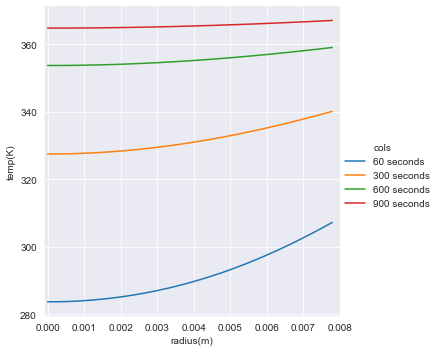

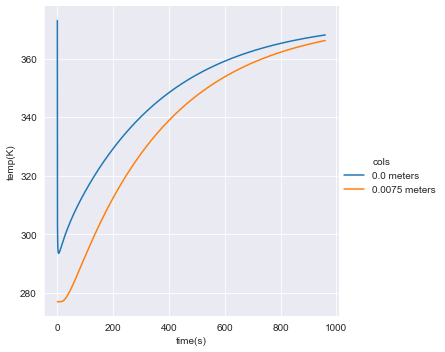

In [75]:
graphIt(df1, 0.0075, 0.569,1029,3810, np.array([60,300,600,900]), np.array([0.0,0.0075]))

We will now note that the way the function is defined is slightly counter intuitive, so distance is calculated from the outside in. So 0 meters is at the ghost node just outside the surface of the carrot and the 0.0075m line is at the center of the carrot because this is the radius of our example